In [15]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime

# Fixed parameters
START_DATE = "2020-09-01"
END_DATE = "2025-01-01"
INTERVAL = "1d"
STOP_LOSS = 0.10
TAX_RATE = 0.15

# Example list of symbols
symbols = [
    "PRIO3.SA",
    "ITUB4.SA",
    "VALE3.SA",
    "ABEV3.SA",
    "RENT3.SA",
    "WEGE3.SA",
    "B3SA3.SA",
    "JBSS3.SA",
    "VIVT3.SA",
    "EGIE3.SA"
]

###############################################################################
# 1) Download data and detect support/resistance
###############################################################################
def is_local_min(df, idx):
    # Checks if df['Low'][idx] is the minimum in a local window
    window_lows = df['Low'].iloc[idx-2 : idx+3]
    return df['Low'].iloc[idx] == window_lows.min()

def is_local_max(df, idx):
    # Checks if df['High'][idx] is the maximum in a local window
    window_highs = df['High'].iloc[idx-2 : idx+3]
    return df['High'].iloc[idx] == window_highs.max()

def sufficiently_far(new_price, accepted_prices, threshold):
    # Ensures that 'new_price' is sufficiently far from any of the accepted prices
    return all(abs(new_price - ap) > threshold for ap in accepted_prices)

# Data structures to hold trades and last-detection info
all_trades_long = []
all_trades_short = []
last_detection_list = []

for symbol in symbols:
    # Download from Yahoo
    data = yf.download(symbol, start=START_DATE, end=END_DATE, interval=INTERVAL)
    if data.empty:
        continue

    # Adjust data if columns are multi-level
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.droplevel(0)

    data.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    data.reset_index(inplace=True)

    df = data[['Date', 'Open', 'High', 'Low', 'Close']].copy()

    # Mark support and resistance
    df['isSupport'] = False
    df['isResistance'] = False
    df['AvgCandleHeight'] = np.nan

    # Local minima/maxima detection
    for t in range(len(df)):
        j = t - 2
        if j - 2 >= 0 and j + 2 < len(df):
            if is_local_min(df, j):
                df.loc[j, 'isSupport'] = True
            if is_local_max(df, j):
                df.loc[j, 'isResistance'] = True

        # Calculate average candle height in the last ~32 days
        window_start = max(0, t - 32 + 1)
        sub_df = df.iloc[window_start : t+1]
        if len(sub_df) > 0:
            df.loc[t, 'AvgCandleHeight'] = np.mean(sub_df['High'] - sub_df['Low'])

    # Gather potential levels and filter them
    raw_levels = []
    for i in range(len(df)):
        if df['isSupport'].iloc[i]:
            raw_levels.append({'index': i, 'price': df['Low'].iloc[i], 'type': 'support'})
        elif df['isResistance'].iloc[i]:
            raw_levels.append({'index': i, 'price': df['High'].iloc[i], 'type': 'resistance'})

    final_levels = []
    unique_prices = []
    for lvl in raw_levels:
        idx = lvl['index']
        candle_height = df['AvgCandleHeight'].iloc[idx]
        if np.isnan(candle_height):
            continue
        if sufficiently_far(lvl['price'], unique_prices, candle_height):
            final_levels.append(lvl)
            unique_prices.append(lvl['price'])

    # Record the last detection info
    if len(final_levels) > 0:
        last_level = final_levels[-1]
        last_detection_type = last_level['type']
        last_detection_idx = last_level['index']
        last_detection_date = df['Date'].iloc[last_detection_idx]
        last_detection_price = last_level['price']

        last_date = df['Date'].iloc[-1]
        last_close_price = df['Close'].iloc[-1]

        diff_rel = (last_close_price / last_detection_price) - 1.0

        last_detection_list.append({
            'symbol': symbol,
            'last_detection_type': last_detection_type,
            'last_detection_date': last_detection_date.strftime('%Y-%m-%d'),
            'last_detection_price': round(last_detection_price, 2),
            'last_date': last_date.strftime('%Y-%m-%d'),
            'last_close_price': round(last_close_price, 2),
            'diff_relative (%)': round(diff_rel * 100, 2)
        })

    ############################################################################
    # 2) Identify and simulate LONG trades
    ############################################################################
    trades_long = []
    for i in range(len(final_levels) - 1):
        if final_levels[i]['type'] == 'support' and final_levels[i+1]['type'] == 'resistance':
            support_idx = final_levels[i]['index']
            resistance_idx = final_levels[i+1]['index']
            if resistance_idx <= support_idx:
                continue

            # Entry is 3 days after the support day
            real_entry_idx = support_idx + 3
            # Exit is 3 days after the resistance day
            real_exit_idx = resistance_idx + 3

            if real_entry_idx >= len(df) or real_exit_idx >= len(df):
                continue

            real_entry_price = df['Close'].iloc[real_entry_idx]
            real_exit_price = df['Close'].iloc[real_exit_idx]

            # Stop Loss check
            max_loss_price = real_entry_price * (1 - STOP_LOSS)
            min_price_slice = df['Low'].iloc[real_entry_idx : real_exit_idx+1].min()
            if min_price_slice < max_loss_price:
                stop_day = df['Low'].iloc[real_entry_idx : real_exit_idx+1].idxmin()
                real_exit_idx = stop_day
                real_exit_price = max_loss_price

            gross_return = (real_exit_price / real_entry_price) - 1.0
            # Tax on profit only
            if gross_return > 0:
                net_return = gross_return * (1 - TAX_RATE)
            else:
                net_return = gross_return

            # Some extra fields
            support_price = final_levels[i]['price']
            resistance_price = final_levels[i+1]['price']
            entry_vs_support_pct_diff = (real_entry_price / support_price) - 1.0
            exit_vs_resistance_pct_diff = (real_exit_price / resistance_price) - 1.0

            # daily return approximation
            trade_days = (df['Date'].iloc[real_exit_idx] - df['Date'].iloc[real_entry_idx]).days
            if trade_days > 0:
                daily_net_return = (1 + net_return)**(1 / trade_days) - 1
            else:
                daily_net_return = 0.0

            trades_long.append({
                'support_date': df['Date'].iloc[support_idx].strftime('%Y-%m-%d'),
                'resistance_date': df['Date'].iloc[resistance_idx].strftime('%Y-%m-%d'),
                'support_price': round(support_price, 2),
                'resistance_price': round(resistance_price, 2),
                'real_entry_date': df['Date'].iloc[real_entry_idx].strftime('%Y-%m-%d'),
                'real_exit_date': df['Date'].iloc[real_exit_idx].strftime('%Y-%m-%d'),
                'real_entry_price': round(real_entry_price, 2),
                'real_exit_price': round(real_exit_price, 2),
                'entry_vs_support_pct_diff': round(entry_vs_support_pct_diff * 100, 2),
                'exit_vs_resistance_pct_diff': round(exit_vs_resistance_pct_diff * 100, 2),
                'gross_return (%)': round(gross_return * 100, 2),
                'net_return (%)': round(net_return * 100, 2),
                'daily_net_return (%)': round(daily_net_return * 100, 2),
                'symbol': symbol
            })

    all_trades_long.extend(trades_long)

    ############################################################################
    # 3) Identify and simulate SHORT trades
    ############################################################################
    trades_short = []
    for i in range(len(final_levels) - 1):
        if final_levels[i]['type'] == 'resistance' and final_levels[i+1]['type'] == 'support':
            resistance_idx = final_levels[i]['index']
            support_idx = final_levels[i+1]['index']
            if support_idx <= resistance_idx:
                continue

            # Entry is 3 days after the resistance day
            real_entry_idx = resistance_idx + 3
            # Exit is 3 days after the support day
            real_exit_idx = support_idx + 3

            if real_entry_idx >= len(df) or real_exit_idx >= len(df):
                continue

            real_entry_price = df['Close'].iloc[real_entry_idx]
            real_exit_price = df['Close'].iloc[real_exit_idx]

            # Stop Loss check (SHORT)
            max_loss_price = real_entry_price * (1 + STOP_LOSS)
            max_price_slice = df['High'].iloc[real_entry_idx : real_exit_idx+1].max()
            if max_price_slice > max_loss_price:
                stop_day = df['High'].iloc[real_entry_idx : real_exit_idx+1].idxmax()
                real_exit_idx = stop_day
                real_exit_price = max_loss_price

            gross_return = (real_entry_price - real_exit_price) / real_entry_price
            if gross_return > 0:
                net_return = gross_return * (1 - TAX_RATE)
            else:
                net_return = gross_return

            # Additional fields
            resistance_price = final_levels[i]['price']
            support_price = final_levels[i+1]['price']
            entry_vs_resistance_pct_diff = (real_entry_price / resistance_price) - 1.0
            exit_vs_support_pct_diff = (real_exit_price / support_price) - 1.0

            trade_days = (df['Date'].iloc[real_exit_idx] - df['Date'].iloc[real_entry_idx]).days
            if trade_days > 0:
                daily_net_return = (1 + net_return)**(1 / trade_days) - 1
            else:
                daily_net_return = 0.0

            trades_short.append({
                'resistance_date': df['Date'].iloc[resistance_idx].strftime('%Y-%m-%d'),
                'support_date': df['Date'].iloc[support_idx].strftime('%Y-%m-%d'),
                'resistance_price': round(resistance_price, 2),
                'support_price': round(support_price, 2),
                'real_entry_date': df['Date'].iloc[real_entry_idx].strftime('%Y-%m-%d'),
                'real_exit_date': df['Date'].iloc[real_exit_idx].strftime('%Y-%m-%d'),
                'real_entry_price': round(real_entry_price, 2),
                'real_exit_price': round(real_exit_price, 2),
                'entry_vs_resistance_pct_diff': round(entry_vs_resistance_pct_diff * 100, 2),
                'exit_vs_support_pct_diff': round(exit_vs_support_pct_diff * 100, 2),
                'gross_return (%)': round(gross_return * 100, 2),
                'net_return (%)': round(net_return * 100, 2),
                'daily_net_return (%)': round(daily_net_return * 100, 2),
                'symbol': symbol
            })

    all_trades_short.extend(trades_short)

###############################################################################
# 4) Combine data into DataFrames
###############################################################################
trade_results_long = pd.DataFrame(all_trades_long)
trade_results_short = pd.DataFrame(all_trades_short)

# Metrics by symbol
if not trade_results_long.empty:
    group_long = trade_results_long.groupby('symbol')
    df_long_metrics = group_long.agg({
        'net_return (%)': lambda x: np.mean(x > 0) * 100,  # Probability of gain in %
        'entry_vs_support_pct_diff': 'mean'
    }).reset_index()
    df_long_metrics.rename(columns={
        'net_return (%)': 'prob_win_long (%)',
        'entry_vs_support_pct_diff': 'avg_entry_vs_support_pct_diff'
    }, inplace=True)
else:
    df_long_metrics = pd.DataFrame(columns=['symbol','prob_win_long (%)','avg_entry_vs_support_pct_diff'])

if not trade_results_short.empty:
    group_short = trade_results_short.groupby('symbol')
    df_short_metrics = group_short.agg({
        'net_return (%)': lambda x: np.mean(x > 0) * 100,
        'entry_vs_resistance_pct_diff': 'mean'
    }).reset_index()
    df_short_metrics.rename(columns={
        'net_return (%)': 'prob_win_short (%)',
        'entry_vs_resistance_pct_diff': 'avg_entry_vs_resistance_pct_diff'
    }, inplace=True)
else:
    df_short_metrics = pd.DataFrame(columns=['symbol','prob_win_short (%)','avg_entry_vs_resistance_pct_diff'])

# Merge LONG and SHORT metrics
df_merged_metrics = pd.merge(
    df_long_metrics,
    df_short_metrics,
    on='symbol',
    how='outer'
)

# Last detection DF
last_detection_df = pd.DataFrame(last_detection_list)
last_detection_df = pd.merge(
    last_detection_df,
    df_merged_metrics,
    on='symbol',
    how='left'
)

# Clean up column names
last_detection_df.rename(columns={
    'prob_win_long (%)': 'prob_win_long',
    'avg_entry_vs_support_pct_diff': 'avg_entry_vs_support_pct_diff',
    'prob_win_short (%)': 'prob_win_short',
    'avg_entry_vs_resistance_pct_diff': 'avg_entry_vs_resistance_pct_diff'
}, inplace=True)

last_detection_df[['prob_win_long','avg_entry_vs_support_pct_diff',
                   'prob_win_short','avg_entry_vs_resistance_pct_diff']] = \
    round(last_detection_df[['prob_win_long','avg_entry_vs_support_pct_diff',
                       'prob_win_short','avg_entry_vs_resistance_pct_diff']].fillna(0), 2)

# Show final data
print("=== TRADE RESULTS (LONG) ===\n")
print(trade_results_long)

print("\n=== TRADE RESULTS (SHORT) ===\n")
print(trade_results_short)

print("\n=== LAST DETECTION DF ===\n")
print(last_detection_df)

=== TRADE RESULTS (LONG) ===

   support_date resistance_date  support_price  resistance_price real_entry_date real_exit_date  real_entry_price  real_exit_price  entry_vs_support_pct_diff  exit_vs_resistance_pct_diff  gross_return (%)  net_return (%)  daily_net_return (%)    symbol
0    2020-10-29      2020-11-27           6.11             10.75      2020-11-04     2020-12-02              6.44            10.18                       5.37                        -5.36             58.04           49.34                  1.44  PRIO3.SA
1    2020-12-03      2020-12-04          10.02             11.80      2020-12-08     2020-12-09             10.80            10.89                       7.81                        -7.71              0.83            0.71                  0.71  PRIO3.SA
2    2021-04-30      2021-07-05          17.97             21.99      2021-05-05     2021-05-13             19.40            17.46                       7.95                       -20.60            -10.00       

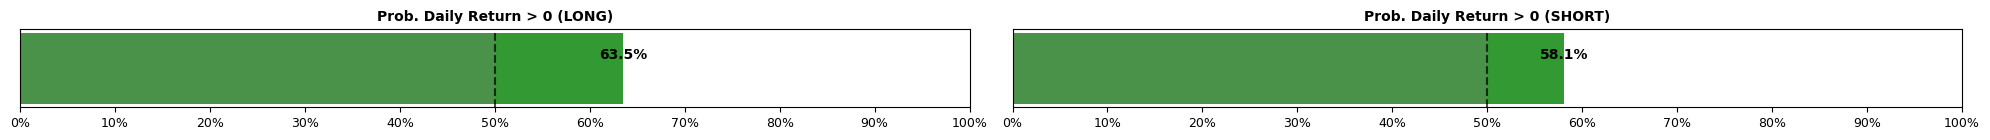

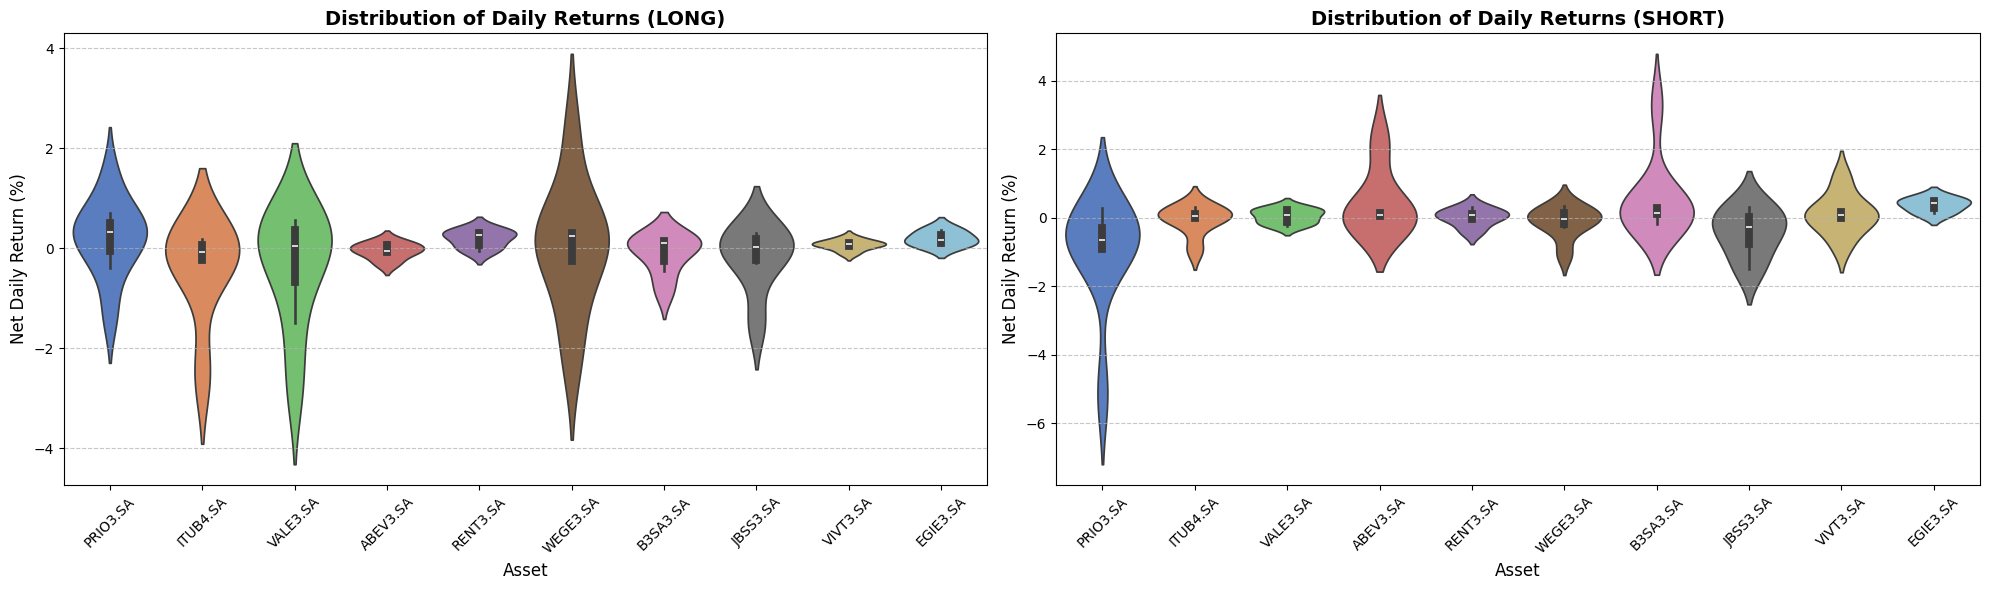

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

positive_returns_long = trade_results_long['daily_net_return (%)'] > 0
probability_positive_long = positive_returns_long.mean()

positive_returns_short = trade_results_short['daily_net_return (%)'] > 0
probability_positive_short = positive_returns_short.mean()

# --- 1) Gauge Charts Side by Side ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 1.5))

# Left: LONG
color_long = 'green' if probability_positive_long > 0.5 else 'red'
ax1.barh([0], [probability_positive_long], color=color_long, height=0.4, alpha=0.8)
ax1.barh([0], [0.5], color='gray', height=0.4, alpha=0.3)
ax1.set_xlim(0, 1)
ax1.set_yticks([])
ax1.set_xticks(np.linspace(0, 1, 11))
ax1.set_xticklabels([f"{int(x*100)}%" for x in np.linspace(0, 1, 11)], fontsize=9)
ax1.set_title('Prob. Daily Return > 0 (LONG)', fontsize=10, fontweight='bold')
ax1.axvline(0.5, color='black', linestyle='--', alpha=0.7)
ax1.text(probability_positive_long, 0.05, f"{probability_positive_long:.1%}",
         ha='center', fontsize=10, fontweight='bold', color='black')

# Right: SHORT
color_short = 'green' if probability_positive_short > 0.5 else 'red'
ax2.barh([0], [probability_positive_short], color=color_short, height=0.4, alpha=0.8)
ax2.barh([0], [0.5], color='gray', height=0.4, alpha=0.3)
ax2.set_xlim(0, 1)
ax2.set_yticks([])
ax2.set_xticks(np.linspace(0, 1, 11))
ax2.set_xticklabels([f"{int(x*100)}%" for x in np.linspace(0, 1, 11)], fontsize=9)
ax2.set_title('Prob. Daily Return > 0 (SHORT)', fontsize=10, fontweight='bold')
ax2.axvline(0.5, color='black', linestyle='--', alpha=0.7)
ax2.text(probability_positive_short, 0.05, f"{probability_positive_short:.1%}",
         ha='center', fontsize=10, fontweight='bold', color='black')

plt.tight_layout()
plt.show()

# --- 2) Violin Plots Side by Side ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Left: LONG Distribution
sns.violinplot(
    data=trade_results_long,
    x='symbol',
    y='daily_net_return (%)',
    hue='symbol',
    palette='muted',
    inner='box',
    ax=ax1
)
ax1.set_title('Distribution of Daily Returns (LONG)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Asset', fontsize=12)
ax1.set_ylabel('Net Daily Return (%)', fontsize=12)
ax1.tick_params(axis='x', rotation=45, labelsize=10)
ax1.tick_params(axis='y', labelsize=10)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Right: SHORT Distribution
sns.violinplot(
    data=trade_results_short,
    x='symbol',
    y='daily_net_return (%)',
    hue='symbol',
    palette='muted',
    inner='box',
    ax=ax2
)
ax2.set_title('Distribution of Daily Returns (SHORT)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Asset', fontsize=12)
ax2.set_ylabel('Net Daily Return (%)', fontsize=12)
ax2.tick_params(axis='x', rotation=45, labelsize=10)
ax2.tick_params(axis='y', labelsize=10)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()